In [1]:
from splice.baseline import DCCA, Karakasis, DCCAE
import numpy as np

import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import math
import torch.nn.functional as F
import pickle
import os

In [2]:
with open(
        "../data/lgn-v1/random_18.9k/random_18.9k_train.pkl",
        "rb",
    ) as f:
        train_data = pickle.load(f)

a_train = torch.Tensor(train_data["responses"]["lgn"][:12096]).to(device)
b_train = torch.Tensor(train_data["responses"]["v1"][:12096]).to(device)

a_validation = torch.Tensor(train_data["responses"]["lgn"][12096:]).to(device)
b_validation = torch.Tensor(train_data["responses"]["v1"][12096:]).to(device)

with open(
        "../data/lgn-v1/random_18.9k/random_18.9k_test.pkl",
        "rb",
    ) as f:
        test_data = pickle.load(f)

a_test = torch.Tensor(test_data["responses"]["lgn"]).to(device)
b_test = torch.Tensor(test_data["responses"]["v1"]).to(device)

### DCCAE

In [29]:
config =  {'batch_size': 800, 'lr': 0.01, 'n_layers': 3, 'weight_decay': 0.001}

In [30]:
model = DCCAE(
            n_a=400,
            n_b=800,
            z_dim=2,
            device=device,
            layers=[64] * config["n_layers"],
            conv=False,
            _lambda=0.2,
        ).to(device)

optimizer = torch.optim.AdamW(
            model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
        )

num_epochs = 30
batch_size = config["batch_size"]

best_loss = np.inf
best_params = None


In [31]:
G = model.update_G(a_train, b_train, batch_size)

for epoch in range(num_epochs):
    if epoch % 1 == 0:
        print("EPOCH %d" % epoch, end=" ")
    else:
        print("EPOCH %d" % epoch, end="\r")
    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]
        g = G[i : i + batch_size]

        a_hat, b_hat, z_a, z_b = model(a_batch, b_batch)
        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
            a_batch, b_batch, a_hat, b_hat, z_a, z_b, g
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, a_hat, b_hat, z_a, z_b

    G = model.update_G(a_train, b_train, batch_size)

    if epoch % 1 == 0:
        x_a_hat, x_b_hat, z_val_a, z_val_b = model(
            a_validation, b_validation
        )

        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
            a_validation,
            b_validation,
            x_a_hat,
            x_b_hat,
            z_val_a,
            z_val_b,
            (z_val_a + z_val_b) / 2,
        )
        if loss < best_loss:
            best_loss = loss
            best_params = model.state_dict()

        if epoch % 1 == 0:
            print("Validation Loss: %.4f" % (loss))

model.load_state_dict(best_params)

x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

EPOCH 0 Validation Loss: 0.0100
EPOCH 1 Validation Loss: 0.0096
EPOCH 2 Validation Loss: 0.0096
EPOCH 3 Validation Loss: 0.0096
EPOCH 4 Validation Loss: 0.0096
EPOCH 5 Validation Loss: 0.0096
EPOCH 6 Validation Loss: 0.0096
EPOCH 7 Validation Loss: 0.0096
EPOCH 8 Validation Loss: 0.0096
EPOCH 9 Validation Loss: 0.0096
EPOCH 10 Validation Loss: 0.0096
EPOCH 11 Validation Loss: 0.0096
EPOCH 12 Validation Loss: 0.0096
EPOCH 13 Validation Loss: 0.0096
EPOCH 14 Validation Loss: 0.0096
EPOCH 15 Validation Loss: 0.0096
EPOCH 16 Validation Loss: 0.0096
EPOCH 17 Validation Loss: 0.0096
EPOCH 18 Validation Loss: 0.0096
EPOCH 19 Validation Loss: 0.0096
EPOCH 20 Validation Loss: 0.0096
EPOCH 21 Validation Loss: 0.0096
EPOCH 22 Validation Loss: 0.0096
EPOCH 23 Validation Loss: 0.0096
EPOCH 24 Validation Loss: 0.0096
EPOCH 25 Validation Loss: 0.0113
EPOCH 26 Validation Loss: 0.0127
EPOCH 27 Validation Loss: 0.0132
EPOCH 28 Validation Loss: 0.0134
EPOCH 29 Validation Loss: 0.0135


In [32]:
model.load_state_dict(best_params)

<All keys matched successfully>

In [45]:
torch.save(model.state_dict(), "../models/lgn-v1/dccae.pt")

In [20]:
model.load_state_dict(torch.load("../models/lgn-v1/dccae.pt"))

<All keys matched successfully>

In [33]:
_,_,z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

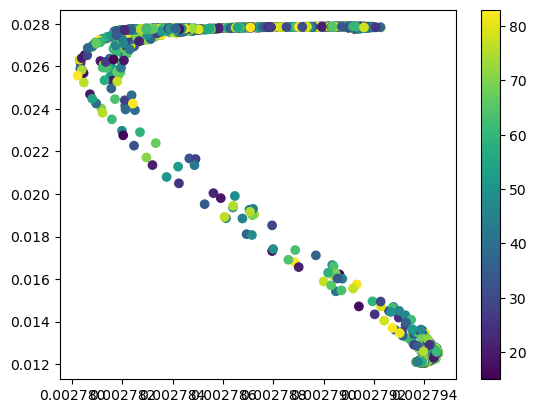

In [44]:
plt.scatter(z_test_a[:,0], z_test_a[:,1], c=test_data["stim_params"]["x"])
plt.colorbar()

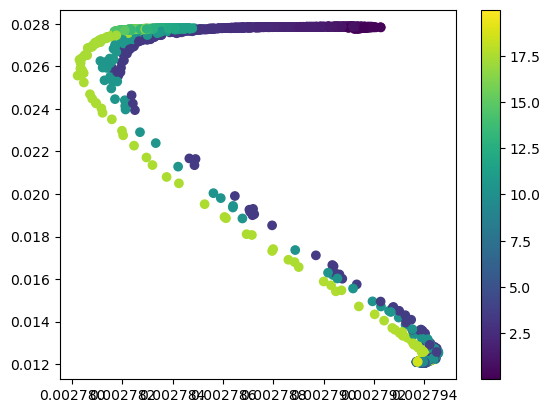

In [40]:
plt.scatter(z_test_a[:,0], z_test_a[:,1], c=test_data["stim_params"]["lgn_p"])
plt.colorbar()

### Karakasis

In [14]:
config =  {'batch_size': 200, 'lr': 0.0001, 'n_layers': 3, 'weight_decay': 0.1}

In [15]:
model = Karakasis(
            n_a=400,
            n_b=800,
            z_dim=2,
            device=device,
            layers=[64] * config["n_layers"],
            conv=False,
            _lambda=10,
        ).to(device)

optimizer = torch.optim.AdamW(
            model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
        )

num_epochs = 100
batch_size = config["batch_size"]

best_loss = np.inf
best_params = None


In [16]:
G = model.update_G(a_train, b_train, batch_size)

for epoch in range(num_epochs):
    if epoch % 1 == 0:
        print("EPOCH %d" % epoch, end=" ")
    else:
        print("EPOCH %d" % epoch, end="\r")
    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]
        g = G[i : i + batch_size]

        a_hat, b_hat, z_a, z_b = model(a_batch, b_batch)
        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
            a_batch, b_batch, a_hat, b_hat, z_a, z_b, g
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, a_hat, b_hat, z_a, z_b

    G = model.update_G(a_train, b_train, batch_size)

    if epoch % 1 == 0:
        x_a_hat, x_b_hat, z_val_a, z_val_b = model(
            a_validation, b_validation
        )

        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
            a_validation,
            b_validation,
            x_a_hat,
            x_b_hat,
            z_val_a,
            z_val_b,
            (z_val_a + z_val_b) / 2,
        )
        if loss < best_loss:
            best_loss = loss
            best_params = model.state_dict()

        if epoch % 1 == 0:
            print("Validation Loss: %.4f" % (loss))

model.load_state_dict(best_params)

x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

EPOCH 0 Validation Loss: 0.0117
EPOCH 1 Validation Loss: 0.0113
EPOCH 2 Validation Loss: 0.0108
EPOCH 3 Validation Loss: 0.0107
EPOCH 4 Validation Loss: 0.0107
EPOCH 5 Validation Loss: 0.0108
EPOCH 6 Validation Loss: 0.0108
EPOCH 7 Validation Loss: 0.0108
EPOCH 8 Validation Loss: 0.0108
EPOCH 9 Validation Loss: 0.0109
EPOCH 10 Validation Loss: 0.0108
EPOCH 11 Validation Loss: 0.0108
EPOCH 12 Validation Loss: 0.0108
EPOCH 13 

KeyboardInterrupt: 

In [48]:
torch.save(model.state_dict(), "../models/lgn-v1/karakasis.pt")

In [49]:
_,_,z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

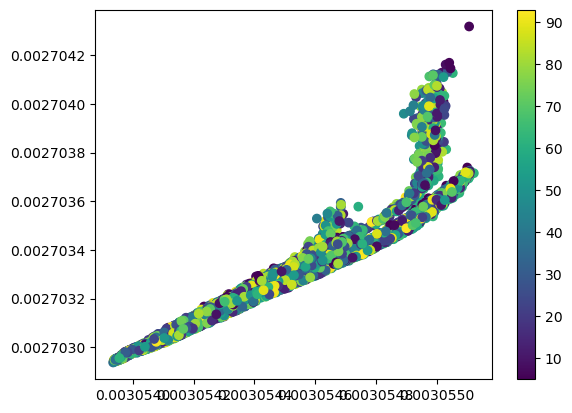

In [56]:
plt.scatter(z_test_b[:,0], z_test_b[:,1], c=test_data["stim_params"]["y"])
plt.colorbar()

### DCCA

In [12]:
config =  {'batch_size': 200, 'lr': 0.0001, 'weight_decay': 0.0001}

In [51]:
model = DCCA(784, 784, 30, device, True)

In [24]:
model = DCCA(784, 784, 30, device, True)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)

num_epochs = 100
batch_size = config["batch_size"]
fail_count = 0
success = False
best_loss = np.inf
best_params = None

G = model.update_G(a_train, b_train, batch_size)

for epoch in range(num_epochs):
    print("EPOCH %d" % (epoch), end="\r")
    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]
        g = G[i : i + batch_size]

        z_a, z_b = model(a_batch, b_batch)
        loss = model.loss(
                             z_a, z_b, g
                        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, z_a, z_b

    G = model.update_G(a_train, b_train, batch_size)

    
    if epoch % 10 == 0:
        z_val_a, z_val_b = model(
                        a_validation, b_validation
                    )

        loss = model.loss(
                        z_val_a,
                        z_val_b,
                        (z_val_a + z_val_b) / 2,
                    )

        if loss < best_loss:
            best_loss = loss.item()
            best_params = model.state_dict()

        print("Validation Loss: %.4f" % (loss))

model.load_state_dict(best_params)

z_train_a = []
z_train_b = []

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

# x_a_hat, x_b_hat, z_a, z_b = model(a_validation, b_validation)

# a_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_a, z_val_a.detach().cpu().numpy()
# )
# b_acc = calculate_mnist_accuracy(
#     labels[50000:60000], z_train_b, z_val_b.detach().cpu().numpy()
# )

# # print("FINISHED")
# accuracy[rep] = max(a_acc, b_acc)
# print(accuracy[rep])
# success = True

Validation Loss: 0.0003
Validation Loss: 0.0002
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0001
Validation Loss: 0.0000
Validation Loss: 0.0000
Validation Loss: 0.0000


In [25]:
torch.save(model.state_dict(), "../models/mnist/dcca_mnist360.pt")

In [53]:
z_train_a = []
z_train_b = []

model.load_state_dict(torch.load("../models/mnist/dcca_mnist360.pt"))

for i in range(0, a_train.shape[0], batch_size):
    a_batch = a_train[i : i + batch_size]
    b_batch = b_train[i : i + batch_size]

    z_a, z_b = model(a_batch, b_batch)
    z_train_a.append(z_a)
    z_train_b.append(z_b)

z_train_a = torch.cat(z_train_a, dim=0).detach().cpu().numpy()
z_train_b = torch.cat(z_train_b, dim=0).detach().cpu().numpy()

In [58]:
z_test_a, z_test_b = model(a_test, b_test)

z_test_a = z_test_a.detach().cpu().numpy()
z_test_b = z_test_b.detach().cpu().numpy()

In [60]:
svm = LinearSVC(max_iter=10000)
svm.fit(z_train_b, labels[:50000].astype(int))
svm.score(z_test_b, labels[60000:].astype(int))

0.907

In [38]:
x_a_hat, x_b_hat, z_a, z_b = model(a_test, b_test)
a_test = a_test.detach().cpu().numpy().squeeze()
b_test = b_test.detach().cpu().numpy().squeeze()
x_a_hat = x_a_hat.detach().cpu().numpy().squeeze()
x_b_hat = x_b_hat.detach().cpu().numpy().squeeze()

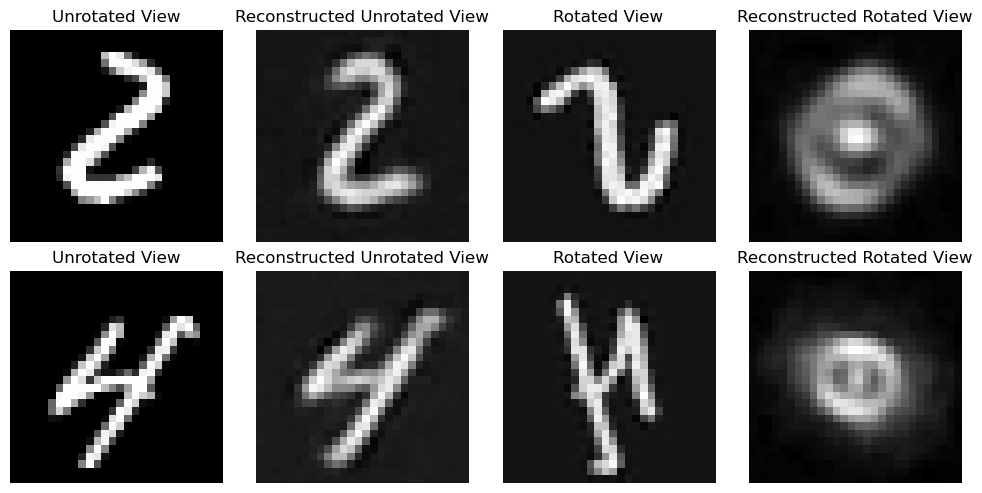

In [42]:
plt.figure(figsize=(10, 5))

ind1 = np.random.choice(10000)
ind2 = np.random.choice(10000)

plt.subplot(2, 4, 1)
plt.imshow(a_test[ind1], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.imshow(x_a_hat[ind1], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 3)
plt.imshow(b_test[ind1], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.imshow(x_b_hat[ind1], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.subplot(2, 4, 5)
plt.imshow(a_test[ind2], cmap="gray")
plt.title("Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.imshow(x_a_hat[ind2], cmap="gray")
plt.title("Reconstructed Unrotated View")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.imshow(b_test[ind2], cmap="gray")
plt.title("Rotated View")
plt.axis("off")

plt.subplot(2, 4, 8)
plt.imshow(x_b_hat[ind2], cmap="gray")
plt.title("Reconstructed Rotated View")
plt.axis("off")

plt.tight_layout()

plt.savefig("../figures/arxiv_figures/Karakasis_reconstructions.svg", transparent=True, dpi=300)

In [48]:
model.load_state_dict(best_params)
x_a_hat, x_b_hat, z_a2b, z_b2a, z_b = model(a_validation, b_validation)

In [23]:
z_b = z_b.detach().cpu().numpy()

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
z_val_a = tsne.fit_transform(z_test_a)
z_val_b = tsne.fit_transform(z_test_b)

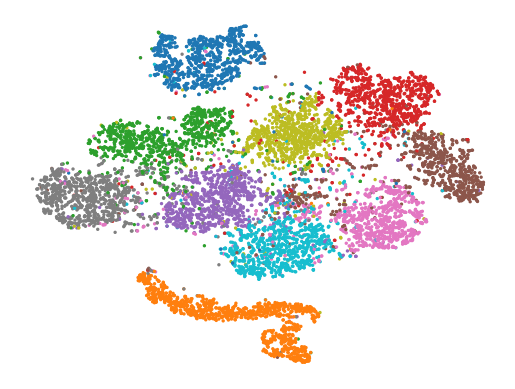

In [66]:
plt.scatter(z_val_b[:, 0], z_val_b[:, 1], c=labels[60000:], cmap="tab10", s=2)
plt.axis("off"); plt.savefig("../figures/arxiv_figures/DCCA_mnist360_tsne.svg", transparent=True, dpi=300)

In [50]:
calculate_mnist_accuracy(labels[50000:60000], z_b2a.detach().cpu().numpy(), z_b2a.detach().cpu().numpy())

c:\Users\Harris_Lab\miniconda3\envs\splice\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.6851